In [1]:
from finlab import login
login('97Y21Yf07Tokqp6rnUxsQKHbc4j+HosTsqE5DNh2oWLA9n+pxaCibJSKUK190ocZ#vip_m')

輸入成功!


In [2]:
import pandas as pd
import numpy as np
from finlab import data
import matplotlib.pyplot as plt

# ======================================
# 0. 參數設定
# ======================================
N_DAYS = 5                # 計算近 N 日漲幅
MIN_LIQ_PCT = 0.6         # 流動性前 60%
TOP_GROUPS = 5           # 每天挑出最強 5 個族群
TOP_STOCKS = 5            # 每個交易日最多選 3 檔股票

# 權重設定 (您可以自由調整這裡的數字)
weights = {
    "ret": 1.5,      # 漲幅權重
    "turnover": 1.0, # 成交額權重
    "inst": 1.0,     # 法人權重
    "conc": 1.0      # 集中度權重
}

# ======================================
# 1. 基礎資料
# ======================================
close = data.get("price:收盤價")
volume = data.get("price:成交股數")

# [新增] 抓取大盤資料 (加權指數)
benchmark = data.get('taiex_total_index:收盤指數')

# 確保抓取到資料再計算
if benchmark is not None and not benchmark.empty:
    # 計算大盤 200MA
    benchmark_ma200 = benchmark.rolling(200).mean()
else:
    # 預防萬一沒抓到資料
    print("Warning: 無法取得大盤資料，將忽略大盤濾網")
    benchmark = pd.Series(dtype=float)
    benchmark_ma200 = pd.Series(dtype=float)

# 族群資料：security_industry_themes 是長表格
theme_raw = data.get("security_industry_themes")

# 法人與主力
foreign = data.get('institutional_investors_trading_summary:外資自營商買賣超股數')
trust = data.get('institutional_investors_trading_summary:投信買賣超股數')
dealer = data.get('institutional_investors_trading_summary:自營商買賣超股數(自行買賣)')

# [新增] 營收資料
rev_yoy = data.get("monthly_revenue:去年同月增減(%)")

# 建立「股票 → 族群」對應表
# 1. 取出每個 stock_id 最新的一筆資料 (假設 key_date 是資料日期)
if 'key_date' in theme_raw.columns:
    theme = theme_raw.sort_values("key_date").groupby("stock_id").last()
else:
    # 如果沒有日期，直接去重
    theme = theme_raw.drop_duplicates("stock_id", keep="last").set_index("stock_id")

# 2. 解析 category 欄位 (字串 "['水泥', ...]")，取第一個當作主族群
def parse_category(cat_str):
    try:
        # 去除括號與引號，取第一個
        # 例如 "['水泥', '...']" -> "水泥"
        return cat_str.replace("[", "").replace("]", "").split(",")[0].strip("' \"")
    except:
        return "Unknown"

if 'category' in theme.columns:
    theme["main_category"] = theme["category"].apply(parse_category)
    group_mapper = theme["main_category"]
else:
    print("Warning: 'category' column not found in theme_raw")
    group_mapper = pd.Series()

# 計算交集 (修正：不直接與 theme_raw.columns 取交集)
common_cols = (
    close.columns
    .intersection(volume.columns)
    .intersection(foreign.columns)
    .intersection(trust.columns)
    .intersection(dealer.columns)
    .intersection(rev_yoy.columns)     # [新增] 確保有營收資料
    .intersection(group_mapper.index)  # 確保有族群分類
)

# 只保留有價格資料的股票，其他資料跟著對齊
close = close[common_cols]
volume = volume[common_cols]
foreign = foreign[common_cols]
trust = trust[common_cols]
dealer = dealer[common_cols]
rev_yoy = rev_yoy[common_cols].reindex(close.index, method='ffill') # [新增] 對齊並補值
group_mapper = group_mapper[common_cols]

# ======================================
# 2. 計算每日因子
# ======================================

# -- 2.1 近 N 日漲幅
ret = close.pct_change(N_DAYS)

# -- 2.2 流動性：成交金額
turnover = close * volume

# -- 2.3 前一日法人買超（外資為例）
inst_total = foreign + trust + dealer
inst_buy_yday = inst_total.shift(1)

# -- 2.4 主力集中度（主力買賣超 / 當日成交量）
inst_concentration = inst_total / volume.replace(0, np.nan)

# ======================================
# 3. 計算「族群強度」：漲幅 + 量 + 法人 + 主力
# ======================================
# 按照 group_mapper（Series：index=股票，value=族群名）做欄方向 groupby

group_ret = ret.groupby(group_mapper, axis=1).mean()            # 族群平均漲幅
group_turnover = turnover.groupby(group_mapper, axis=1).sum()   # 族群總成交額
group_inst = inst_buy_yday.groupby(group_mapper, axis=1).sum()  # 族群總法人買超
group_conc = inst_concentration.groupby(group_mapper, axis=1).mean()  # 族群平均主力集中度

# 計算加權分數
group_score = (
      group_ret.rank(axis=1, pct=True) * weights["ret"]
    + group_turnover.rank(axis=1, pct=True) * weights["turnover"]
    + group_inst.rank(axis=1, pct=True) * weights["inst"]
    + group_conc.rank(axis=1, pct=True) * weights["conc"]
)

# 每天挑出最強 TOP_GROUPS 個族群
top_groups_daily = group_score.rank(axis=1, ascending=False) <= TOP_GROUPS

# ======================================
# 4. 在強勢族群中挑個股（四條件）
# ======================================
selected_stocks = {}  # {日期: [股票列表]}

for date in close.index:

    if date not in top_groups_daily.index:
        continue

    # 1️⃣ 這一天最強的族群名稱
    strong_groups_mask = top_groups_daily.loc[date]
    strong_groups = strong_groups_mask[strong_groups_mask].index.tolist()
    if len(strong_groups) == 0:
        continue

    # 2️⃣ 這些族群底下的股票（用 group_mapper 反查）
    stocks_in_groups = group_mapper[group_mapper.isin(strong_groups)].index.tolist()
    if len(stocks_in_groups) == 0:
        continue
    
    # [新增] 檢查日期是否存在於所有需要的 DataFrame 中，避免 KeyError
    if date not in inst_buy_yday.index or date not in inst_concentration.index:
        continue

    # 3️⃣ 把這些股票當天的四個因子抓出來
    df = pd.DataFrame({
        "ret": ret.loc[date, stocks_in_groups],
        "turnover": turnover.loc[date, stocks_in_groups],
        "inst": inst_buy_yday.loc[date, stocks_in_groups],
        "conc": inst_concentration.loc[date, stocks_in_groups],
        "yoy": rev_yoy.loc[date, stocks_in_groups] # [新增] 加入 YOY
    }).dropna()

    if df.empty:
        continue

    # 4️⃣ 條件過濾
    # (a) 流動性在前 MIN_LIQ_PCT（例如前 60% 最大成交額）
    liq_cut = df["turnover"].quantile(1 - MIN_LIQ_PCT)
    df = df[df["turnover"] >= liq_cut]

    # (b) 前一日法人買超 > 0
    df = df[df["inst"] > 0]

    # (c) 主力集中度為正（主力買超佔成交量為正）
    df = df[df["conc"] > 0]
    
    # (d) [新增] 月營收 YOY > 0
    df = df[df["yoy"] > 0]

    if df.empty:
        continue

    # 5️⃣ 個股綜合分數（跟族群一樣，用 rank 組合）
    df["score"] = (
        df["ret"].rank(pct=True) * weights["ret"]
        + df["turnover"].rank(pct=True) * weights["turnover"]
        + df["inst"].rank(pct=True) * weights["inst"]
        + df["conc"].rank(pct=True) * weights["conc"]
    )

    df = df.sort_values("score", ascending=False).head(TOP_STOCKS)
    selected_stocks[date] = df.index.tolist()

# ======================================
# 5. 結果呈現：轉成 DataFrame 並加上名稱與產業
# ======================================
# 1. 將字典轉為 DataFrame，索引為日期
df_selected = pd.DataFrame.from_dict(selected_stocks, orient='index').sort_index()

# 2. 定義轉換函數：將代號轉為 "代號 名稱 (產業)"
def get_display_info(stock_id):
    if pd.isna(stock_id):
        return ""
    
    stock_id = str(stock_id)
    if stock_id in theme.index:
        row = theme.loc[stock_id]
        name = row['name'] if 'name' in row else ''
        # main_category 是我們在上一步解析出來的
        category = row['main_category'] if 'main_category' in row else ''
        return f"{stock_id} {name} ({category})"
    else:
        return stock_id

# 3. 套用轉換
df_display = df_selected.applymap(get_display_info)

# 4. 顯示最近 10 個交易日的選股結果
print("Saving selected stocks to 'selected_stocks_all_YOY.csv'...")
df_display.to_csv('selected_stocks_all_YOY.csv', encoding='utf-8-sig')
df_display.tail(20)

Saving selected stocks to 'selected_stocks_all_YOY.csv'...


,0,1,2,3,4
2025-12-08,2408 南亞科 (半導體),2337 旺宏 (半導體),3037 欣興 (印刷電路板),3711 日月光投控 (半導體),3653 健策 (半導體)
2025-12-09,8299 群聯 (半導體),2408 南亞科 (半導體),3105 穩懋 (半導體),2404 漢唐 (其他),2337 旺宏 (半導體)
2025-12-10,8358 金居 (印刷電路板),3037 欣興 (印刷電路板),1785 光洋科 (其他),2404 漢唐 (其他),8039 台虹 (印刷電路板)
2025-12-11,2345 智邦 (通信網路),2404 漢唐 (其他),8358 金居 (印刷電路板),2383 台光電 (印刷電路板),3715 定穎投控 (印刷電路板)
2025-12-12,2404 漢唐 (其他),1785 光洋科 (其他),2059 川湖 (其他),3211 順達 (能源元件),6196 帆宣 (其他)
2025-12-15,2345 智邦 (通信網路),2404 漢唐 (其他),6139 亞翔 (其他),5439 高技 (印刷電路板),2383 台光電 (印刷電路板)
2025-12-16,2345 智邦 (通信網路),2404 漢唐 (其他),6944 兆聯實業 (其他),3563 牧德 (印刷電路板),2059 川湖 (其他)
2025-12-17,2887 台新新光金 (金融),2884 玉山金 (金融),6944 兆聯實業 (其他),2880 華南金 (金融),2404 漢唐 (其他)
2025-12-18,2887 台新新光金 (金融),2880 華南金 (金融),2884 玉山金 (金融),2345 智邦 (通信網路),2883 凱基金 (金融)
2025-12-19,3045 台灣大 (通信網路),2345 智邦 (通信網路),6753 龍德造船 (其他),3703 欣陸 (其他),1215 卜蜂 (食品)


開始回測 (固定持有 + 大盤濾網)
期間: 2008-02-13 ~ 2026-01-06
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 4343
總損益: 8,661,036
平均報酬率: 2.00%
勝率: 42.74%
平均持有天數: 30.9 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
4333,3231,2025-10-23,2025-12-19,142.0,144.0,Time Exit (40 days),1075.180480,0.010754,704,40
4334,6173,2025-10-28,2025-12-23,64.0,67.2,Time Exit (40 days),4654.297648,0.046551,1562,40
4335,2345,2025-10-30,2025-12-26,987.0,1215.0,Time Exit (40 days),22628.162715,0.226960,101,40
4336,9802,2025-12-05,2025-12-26,115.0,102.5,Stop Loss (-10.0%),-11156.651069,-0.111623,869,14
4337,1519,2025-10-31,2025-12-29,655.0,778.0,Time Exit (40 days),18310.193220,0.183885,152,40
4338,2368,2025-11-03,2025-12-30,480.0,692.0,Time Exit (40 days),43629.453920,0.436931,208,40
4339,2379,2025-12-04,2025-12-30,537.0,481.0,Stop Loss (-10.0%),-10711.380090,-0.107225,186,17
4340,2383,2025-11-04,2025-12-31,1440.0,1645.0,Time Exit (40 days),13774.151738,0.138609,69,40
4341,2059,2025-12-15,2026-01-05,3615.0,3205.0,Stop Loss (-10.0%),-11355.844950,-0.116328,27,13
4342,8021,2025-11-07,2026-01-06,123.5,183.5,Time Exit (40 days),48059.253772,0.480950,809,40


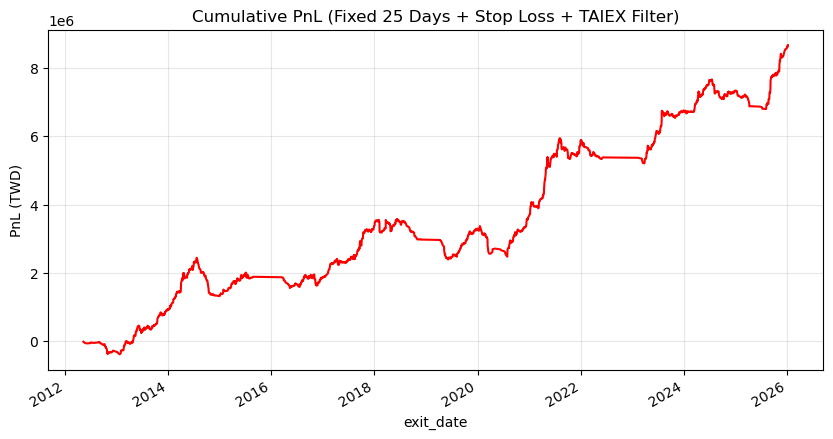

In [3]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding + Stop Loss) + 大盤濾網 (修正版)
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 25 天
COOLING_OFF_DAYS = 5          # 進場冷卻期 20 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間 (同前)
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    # 使用 .at 來確保取回的是單一純量值，而非 Series
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # benchmark 有可能有多個欄位 (雖然看起來像 Series)，為了保險使用 .iloc[0] 或 .item()
        # 或者確保 benchmark 本身是 Series
        
        # 情境 1: benchmark 是 DataFrame
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        # 進行比較
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    # 如果大盤濾網未通過，則今天完全不開新倉
    if not market_filter_pass:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 25 Days + Stop Loss + TAIEX Filter)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

開始回測 (固定持有 + 大盤濾網 + 每月10-15日進場)
期間: 2008-02-13 ~ 2026-01-06
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 1477
總損益: 4,430,190
平均報酬率: 3.00%
勝率: 46.17%
平均持有天數: 31.9 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
1467,3443,2025-10-13,2025-12-09,1450.00,2115.00,Time Exit (40 days),44753.995150,0.453830,68,40
1468,8996,2025-10-14,2025-12-10,460.50,510.00,Time Exit (40 days),10379.479714,0.103854,217,40
1469,6603,2025-10-14,2025-12-10,19.65,23.40,Time Exit (40 days),18691.609428,0.186928,5088,40
1470,6139,2025-10-15,2025-12-11,418.00,528.00,Time Exit (40 days),25879.205605,0.259009,239,40
1471,2211,2025-10-15,2025-12-11,110.50,112.50,Time Exit (40 days),1474.173140,0.014756,904,40
1472,3002,2025-10-15,2025-12-11,20.25,27.30,Time Exit (40 days),34368.057205,0.343720,4937,40
1473,1609,2025-10-15,2025-12-11,41.50,38.15,Time Exit (40 days),-8373.202501,-0.083742,2409,40
1474,8358,2025-12-11,2025-12-16,288.00,247.00,Stop Loss (-10.0%),-14510.581413,-0.145178,347,3
1475,8039,2025-12-11,2026-01-05,94.20,82.20,Stop Loss (-10.0%),-13020.312957,-0.130255,1061,15
1476,2059,2025-12-15,2026-01-05,3615.00,3205.00,Stop Loss (-10.0%),-11355.844950,-0.116328,27,13


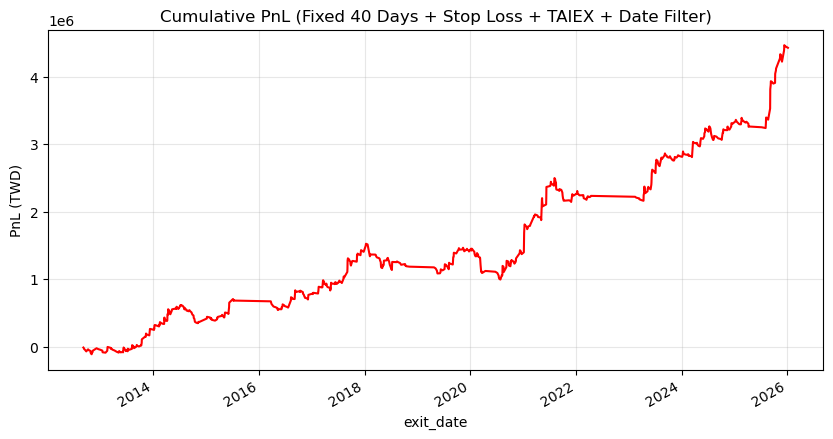


[2026-01-06] 目前持股: 24 檔
策略設定出場天數: 40 (Trading Days)


,Stock ID,Entry Date,Entry Price,Current Price,Shares,Cost,Mkt Value,Unrealized PnL,ROI (%),Trading Days,Calendar Days
0,1303 南亞 (印刷電路板),2025-11-10,43.50,58.90,2298,99977,135352,34949,34.96,39,57
2,2368 金像電 (印刷電路板),2025-11-10,473.00,662.00,211,99817,139682,39425,39.50,39,57
1,2890 永豐金 (金融),2025-11-10,26.65,29.00,3751,99978,108779,8458,8.46,39,57
3,2887 台新新光金 (金融),2025-11-11,19.25,20.90,5194,99998,108554,8214,8.21,38,56
4,2731 雄獅 (休閒娛樂),2025-11-11,175.00,164.50,571,99939,93929,-6304,-6.31,38,56
5,2880 華南金 (金融),2025-11-11,29.50,31.60,3389,99989,107092,6766,6.77,38,56
6,3443 創意 (半導體),2025-11-12,1990.00,2485.00,50,99514,124250,24345,24.46,37,55
7,6770 力積電 (半導體),2025-11-12,33.45,47.75,2989,99996,142724,42279,42.28,37,55
8,2481 強茂 (半導體),2025-11-12,81.00,79.20,1234,99968,97732,-2542,-2.54,37,55
9,6274 台燿 (印刷電路板),2025-11-13,403.00,476.00,248,99958,118048,17718,17.73,36,54


In [4]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding + Stop Loss) + 大盤濾網 + 日期濾網
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 40 天
COOLING_OFF_DAYS = 5           # 進場冷卻期 5 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網 + 每月10-15日進場)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # benchmark 有可能有多個欄位 (雖然看起來像 Series)，為了保險使用 .iloc[0] 或 .item()
        # 情境 1: benchmark 是 DataFrame
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        # 進行比較
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    # 如果大盤濾網未通過，則今天完全不開新倉
    if not market_filter_pass:
        continue

    # [新增] 限制每月 12 日前才進場 (包含 12 日)
    if today.day > 15 or today.day < 10:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 40 Days + Stop Loss + TAIEX + Date Filter)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

# ======================================
# [新增功能] 顯示目前持股清單與未實現損益
# ======================================
current_date = backtest_dates[-1]
current_idx = len(backtest_dates) - 1  # 取得目前最後一天的 index
print(f"\n[{current_date.date()}] 目前持股: {len(positions)} 檔")
print(f"策略設定出場天數: {FIXED_HOLDING_DAYS} (Trading Days)")
if positions:
    holdings_list = []
    for pos in positions:
        stock_id = pos['stock_id']
        # 取得最後一天的價格
        curr_price = close_.at[current_date, stock_id] if stock_id in close_.columns and current_date in close_.index else float('nan')
        
        # 計算未實現損益
        market_val = curr_price * pos['shares'] if pd.notna(curr_price) else 0
        est_net_val = market_val * (1 - FEE_RATE - TAX_RATE)
        unrealized_pnl = est_net_val - pos['cost']
        roi = (unrealized_pnl / pos['cost']) * 100 if pos['cost'] != 0 else 0
        
        # [修正] 計算交易日數 (Trading Days)
        trading_days_held = current_idx - pos['entry_idx']
        
        # [選擇性] 計算日曆日數 (Calendar Days)
        calendar_days_held = (current_date - pos['entry_date']).days
        
        holdings_list.append({
            'Stock ID': get_display_info(stock_id),
            'Entry Date': pos['entry_date'].date(),
            'Entry Price': pos['entry_price'],
            'Current Price': curr_price,
            'Shares': pos['shares'],
            'Cost': int(pos['cost']),
            'Mkt Value': int(market_val),
            'Unrealized PnL': int(unrealized_pnl),
            'ROI (%)': round(roi, 2),
            'Trading Days': trading_days_held,   # 策略用的 K 棒數 (還沒到 40 就不會賣)
            'Calendar Days': calendar_days_held  # 自然天數 (含假日)
        })
        
    df_holdings = pd.DataFrame(holdings_list)
    # 按照持有天數排序觀察
    display(df_holdings.sort_values("Trading Days", ascending=False))
else:
    print("目前無持股")

------------------------------
策略效能總結表 (基準本金: 4,500,000)
------------------------------
1. 總損益 (PnL):      4,430,190 元
2. 總報酬率:          98.45 %
3. 年化報酬率 (CAGR): 3.90 %
4. 最大回撤 (MDD):    -8.81 %
5. 獲利因子 (PF):     1.59
6. 夏普比率 (Sharpe): 1.04
------------------------------
MDD 發生日期: 2020-07-28


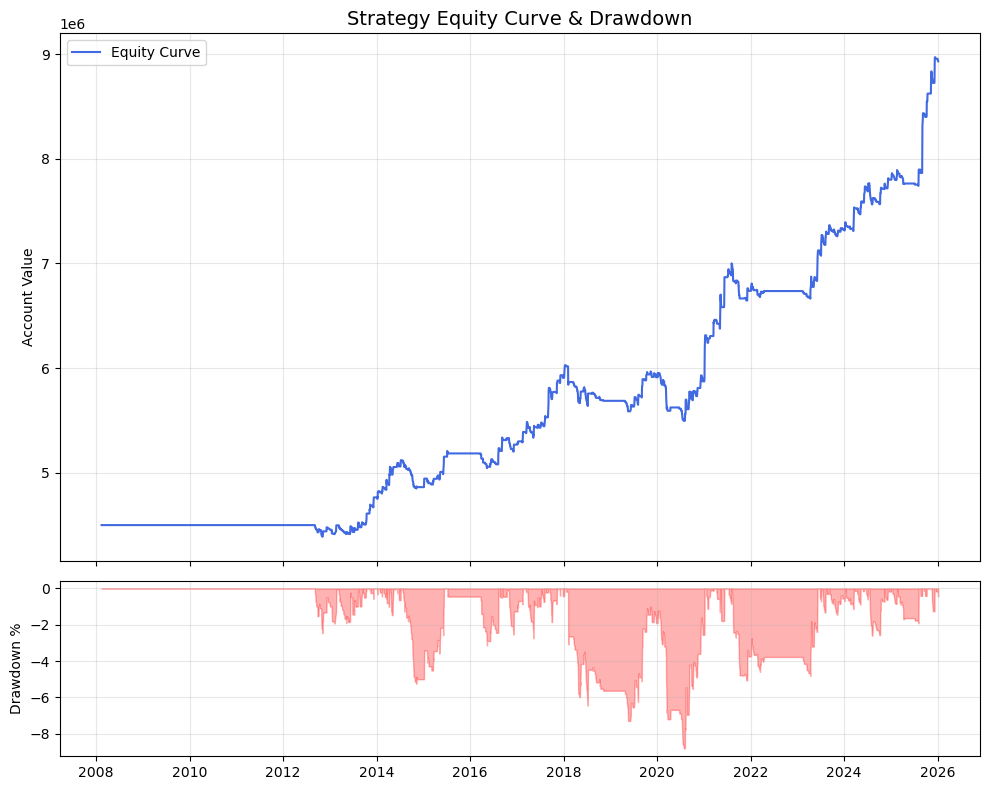

In [5]:
# ======================================
# [新增功能] 策略核心績效指標計算 (MDD, Sharpe, Profit Factor, CAGR)
# ======================================
import numpy as np

# 1. 準備金設定 (以您之前算出的最高曝光額作為本金參考值)
INITIAL_CAPITAL = 4500000  # 假設準備金為 450 萬

# 2. 建立每日權益曲線 (Realized PnL)
# 先統計每日實現損益
daily_realized_pnl = df_trades.groupby("exit_date")["pnl"].sum().reindex(backtest_dates, fill_value=0)
# 累計損益 + 本金
equity_curve = daily_realized_pnl.cumsum() + INITIAL_CAPITAL

# 3. 計算最大回撤 (MDD)
# 找出歷史最高點
running_max = equity_curve.cummax()
# 計算回撤金額與百分比
drawdown_amt = equity_curve - running_max
drawdown_pct = drawdown_amt / running_max
mdd_pct = drawdown_pct.min()
mdd_date = drawdown_pct.idxmin()

# 4. 計算年化報酬率 (CAGR)
total_days = (backtest_dates[-1] - backtest_dates[0]).days
years = total_days / 365.25
total_return = (equity_curve.iloc[-1] / INITIAL_CAPITAL) - 1
cagr = (1 + total_return)**(1/years) - 1

# 5. 計算夏普比率 (Sharpe Ratio)
# 使用每日收益率計算（假設無風險利率為 1%）
daily_returns = equity_curve.pct_change().dropna()
# 年化報酬率 / 年化標普 (通常乘上 sqrt(252) 代表交易日)
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# 6. 獲利因子 (Profit Factor)
gross_profit = df_trades[df_trades['pnl'] > 0]['pnl'].sum()
gross_loss = abs(df_trades[df_trades['pnl'] < 0]['pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

# ======================================
# 顯示報表
# ======================================
print("-" * 30)
print(f"策略效能總結表 (基準本金: {INITIAL_CAPITAL:,.0f})")
print("-" * 30)
print(f"1. 總損益 (PnL):      {df_trades['pnl'].sum():,.0f} 元")
print(f"2. 總報酬率:          {total_return*100:.2f} %")
print(f"3. 年化報酬率 (CAGR): {cagr*100:.2f} %")
print(f"4. 最大回撤 (MDD):    {mdd_pct*100:.2f} %")
print(f"5. 獲利因子 (PF):     {profit_factor:.2f}")
print(f"6. 夏普比率 (Sharpe): {sharpe_ratio:.2f}")
print("-" * 30)
print(f"MDD 發生日期: {mdd_date.date()}")

# 繪製資產曲線與回撤圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(equity_curve, color='royalblue', label='Equity Curve')
ax1.set_title("Strategy Equity Curve & Drawdown", fontsize=14)
ax1.set_ylabel("Account Value")
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.fill_between(drawdown_pct.index, drawdown_pct * 100, 0, color='red', alpha=0.3)
ax2.set_ylabel("Drawdown %")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

開始回測 (移動停利 + 40天低獲利強制出場)
期間: 2008-02-13 ~ 2026-01-06
出場邏輯: 1.硬停損 10%  2.獲利達 10% 後破 20MA 停利  3.持有 40 天獲利不足 5% 出場

總交易次數: 1434
總損益: 4,019,621
平均報酬率: 2.81%
勝率: 50.28%
平均持有天數: 28.8 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
1424,1609,2025-10-15,2025-12-11,41.5,38.15,"Eff. Exit (Day 40, <5.0% Profit)",-8373.202501,-0.083742,2409,40
1425,2481,2025-11-12,2025-12-12,81.0,83.80,20MA Trailing Stop,3115.993144,0.031170,1234,22
1426,2330,2025-10-13,2025-12-15,1390.0,1450.00,"Eff. Exit (Day 40, <5.0% Profit)",3922.416300,0.039739,71,44
1427,1303,2025-11-10,2025-12-16,43.5,58.20,20MA Trailing Stop,33346.066010,0.333537,2298,26
1428,3443,2025-11-12,2025-12-16,1990.0,2020.00,20MA Trailing Stop,1168.428750,0.011741,50,24
1429,2368,2025-11-10,2025-12-17,473.0,586.00,20MA Trailing Stop,23440.220517,0.234831,211,27
1430,6442,2025-11-14,2025-12-17,1010.0,1215.00,20MA Trailing Stop,19701.717875,0.199019,98,23
1431,8358,2025-11-14,2025-12-17,223.5,238.50,20MA Trailing Stop,6355.743255,0.063609,447,23
1432,8039,2025-12-11,2026-01-05,94.2,82.20,Stop Loss (-10.0%),-13020.312957,-0.130255,1061,15
1433,2059,2025-12-15,2026-01-05,3615.0,3205.00,Stop Loss (-10.0%),-11355.844950,-0.116328,27,13


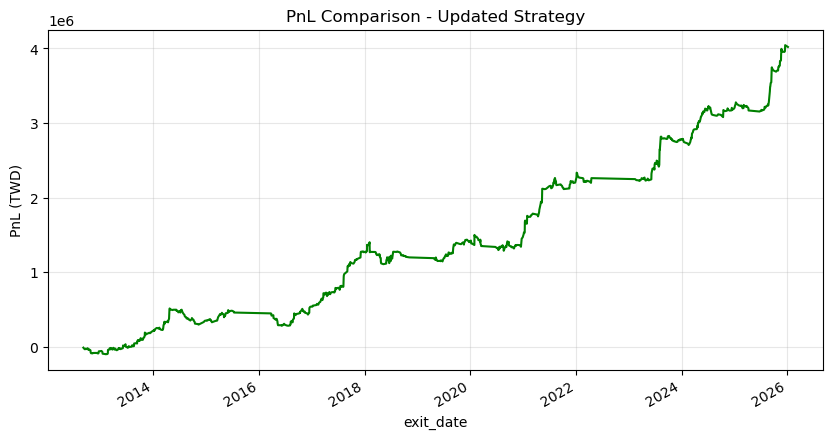


      出場原因統計分析
                                   次數  比例 (%)  平均報酬 (%)
reason                                                 
20MA Trailing Stop                643   44.84     15.32
Stop Loss (-10.0%)                437   30.47    -12.09
Eff. Exit (Day 40, <5.0% Profit)  354   24.69     -1.55


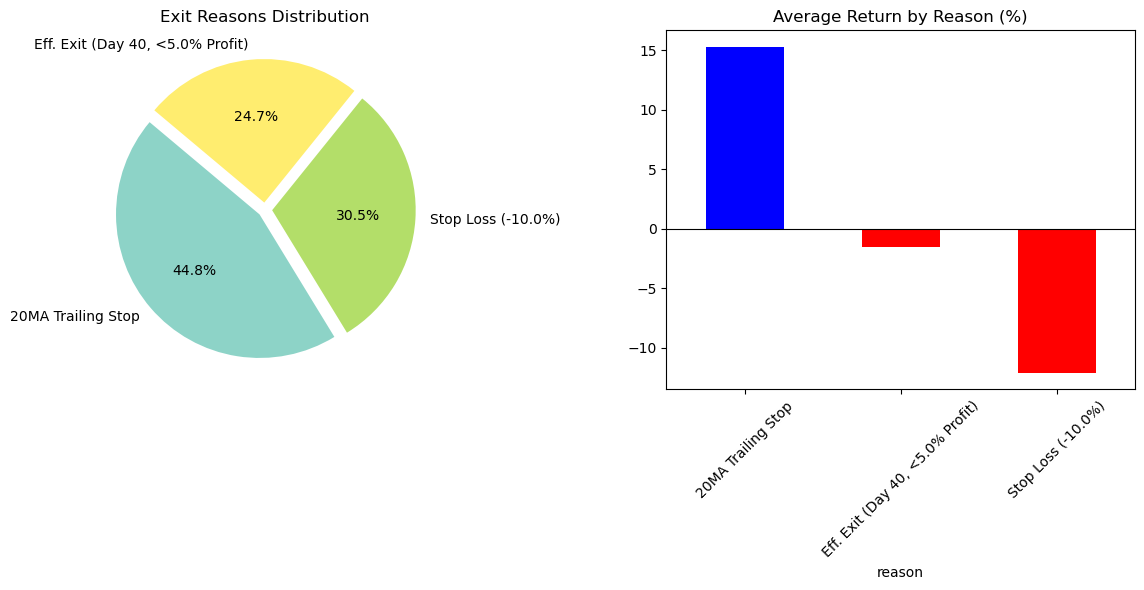


[分析結果]
最主要的出場原因是: 20MA Trailing Stop，佔比約 44.8%。
💡 移動停利 (20MA) 執行了 643 次，其平均報酬為 15.32%。


In [6]:
# ======================================
# 9. 優化策略：移動停利 + 啟動門檻 + 40天效率出場條件
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# 計算均線
ma60 = close_.rolling(60).mean()   # 進場濾網
ma20 = close_.rolling(20).mean()   # 出場停利線

# [確保] 抓取大盤資料
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10             # 硬停損 10%
PROFIT_THRESHOLD = 0.10          # 獲利 10% 啟動均線停利
TIME_EXIT_DAYS = 40              # 效率檢查天數
TIME_EXIT_PROFIT_LIMIT = 0.05    # 持有滿 40 天若獲利低於 5% 則出場
COOLING_OFF_DAYS = 5             # 冷卻期
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (移動停利 + 40天低獲利強制出場)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"出場邏輯: 1.硬停損 10%  2.獲利達 10% 後破 20MA 停利  3.持有 40 天獲利不足 5% 出場")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        current_ma20 = ma20.at[today, stock_id]
        held_days = i - pos['entry_idx'] # 目前已持有天數 (K棒數)
        
        # 計算當前報酬率
        current_return = (current_close / pos['entry_price']) - 1
        
        # 追蹤持有期間最高報酬
        if current_return > pos['max_return']:
            pos['max_return'] = current_return
        
        exit_reason = None
        
        # 1. 優先檢查硬停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 獲利啟動 20MA 停利機制
        if not exit_reason and pos['max_return'] >= PROFIT_THRESHOLD:
            if pd.notna(current_ma20) and current_close < current_ma20:
                exit_reason = "20MA Trailing Stop"
        
        # 3. [新增] 效率出場條件：持有滿 40 天且獲利低於 5%
        if not exit_reason:
            if held_days >= TIME_EXIT_DAYS and current_return < TIME_EXIT_PROFIT_LIMIT:
                exit_reason = f"Eff. Exit (Day {TIME_EXIT_DAYS}, <{TIME_EXIT_PROFIT_LIMIT*100}% Profit)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': held_days 
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        bm_val = benchmark.at[yesterday, benchmark.columns[0]] if isinstance(benchmark, pd.DataFrame) else benchmark.at[yesterday]
        ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]] if isinstance(benchmark_ma200, pd.DataFrame) else benchmark_ma200.at[yesterday]
        if pd.notna(bm_val) and pd.notna(ma_val) and bm_val <= ma_val:
            market_filter_pass = False
    
    if not market_filter_pass:
        continue

    # 每月進場窗口
    if today.day > 15 or today.day < 10:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 60MA 進場濾網
        if pd.isna(ma60.at[yesterday, stock_id]) or close_.at[yesterday, stock_id] <= ma60.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        if last_date is not None:
            try:
                if (close_.index.get_loc(yesterday) - close_.index.get_loc(last_date)) <= COOLING_OFF_DAYS:
                    continue
            except: pass
        
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            last_selected_date[stock_id] = yesterday
            cost = entry_price * shares * (1 + FEE_RATE)
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i,
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost,
                'max_return': 0 
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 繪製權益曲線
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="green", title="PnL Comparison - Updated Strategy")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

# ======================================
# 10. 出場原因統計分析
# ======================================
if not df_trades.empty:
    print("\n" + "="*30)
    print("      出場原因統計分析")
    print("="*30)
    
    # 1. 計算各原因的次數與比例
    exit_counts = df_trades['reason'].value_counts()
    exit_pct = df_trades['reason'].value_counts(normalize=True) * 100
    
    # 2. 合併成 DataFrame 顯示
    analysis_df = pd.DataFrame({
        '次數': exit_counts,
        '比例 (%)': exit_pct.round(2)
    })
    
    # 3. 計算各出場原因的平均報酬率
    avg_ret_per_reason = df_trades.groupby('reason')['return'].mean() * 100
    analysis_df['平均報酬 (%)'] = avg_ret_per_reason.round(2)
    
    print(analysis_df)
    
    # 4. 繪製圓餅圖
    plt.figure(figsize=(12, 6))
    
    # 左圖：比例分布
    plt.subplot(1, 2, 1)
    exit_counts.plot.pie(autopct='%1.1f%%', startangle=140, cmap='Set3', explode=[0.05]*len(exit_counts))
    plt.title("Exit Reasons Distribution")
    plt.ylabel("") # 隱藏 y 軸標籤
    
    # 右圖：各原因的盈虧貢獻
    plt.subplot(1, 2, 2)
    avg_ret_per_reason.plot(kind='bar', color=['red' if x<0 else 'blue' for x in avg_ret_per_reason])
    plt.title("Average Return by Reason (%)")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

    # 5. 文字分析建議
    most_common = exit_counts.index[0]
    print(f"\n[分析結果]")
    print(f"最主要的出場原因是: {most_common}，佔比約 {exit_pct[most_common]:.1f}%。")
    
    if "Stop Loss" in exit_pct and exit_pct.get("Stop Loss", 0) > 40:
        print("💡 警示：硬停損比例過高，建議回頭檢查進場訊號是否過於頻繁或大盤趨勢過弱。")
    
    if "20MA Trailing Stop" in exit_pct:
         print(f"💡 移動停利 (20MA) 執行了 {exit_counts.get('20MA Trailing Stop', 0)} 次，其平均報酬為 {avg_ret_per_reason.get('20MA Trailing Stop', 0):.2f}%。")

else:
    print("無交易紀錄可供分析")

策略期間同時間最高的「未平倉總金額」: 3,918,455 元
發生日期: 2014-03-14


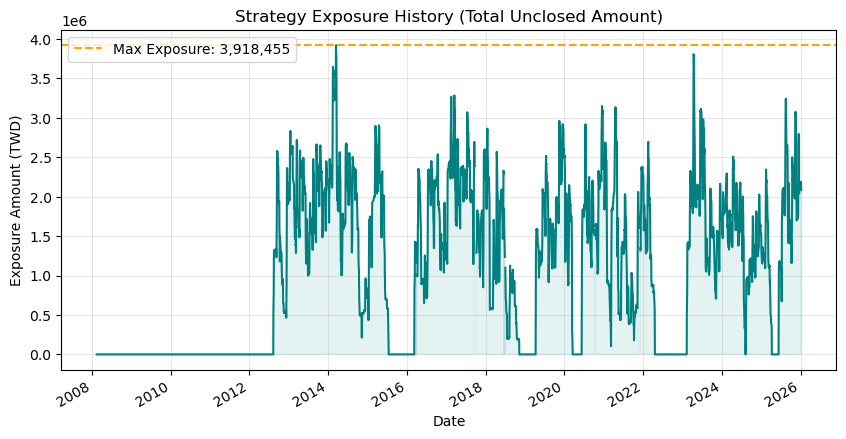

In [7]:
# ======================================
# [新增功能] 計算回測期間最高的「未平倉總金額」(Exposure)
# ======================================
import pandas as pd
import matplotlib.pyplot as plt

# 確保變數存在且不為空
if 'trade_history' in locals() and 'backtest_dates' in locals():
    # 建立一個與回測期間相同的序列來存放每日暴露額
    exposure_series = pd.Series(0.0, index=backtest_dates)

    # 1. 建立所有交易清單 (包含已完成的 + 回測結束時還在場內的)
    all_trades_for_exposure = trade_history.copy()
    for pos in positions:
        all_trades_for_exposure.append({
            'stock_id': pos['stock_id'],
            'entry_date': pos['entry_date'],
            'exit_date': backtest_dates[-1], # 最後一天尚未平倉，以回測最後一日計
            'shares': pos['shares']
        })

    # 2. 累加每日的未平倉金額
    # 遍歷每個交易，計算該交易持有期間每一天的市值，並累加到曝光額序列中
    for t in all_trades_for_exposure:
        s_id = t['stock_id']
        start_date = t['entry_date']
        end_date = t['exit_date']
        shares = t['shares']
        
        if s_id in close_.columns:
            # 取得該股在持有期間的收盤價
            holding_prices = close_.loc[start_date:end_date, s_id]
            # 每日市值 = 股數 * 當日收盤價
            exposure_series[holding_prices.index] += (holding_prices * shares)

    # 3. 統計結果
    max_exposure_val = exposure_series.max()
    max_exposure_dt = exposure_series.idxmax()

    print(f"策略期間同時間最高的「未平倉總金額」: {max_exposure_val:,.0f} 元")
    print(f"發生日期: {max_exposure_dt.date()}")

    # 4. 繪製 Exposure 變化圖表
    plt.figure(figsize=(10, 5))
    exposure_series.plot(title="Strategy Exposure History (Total Unclosed Amount)", color='teal', linewidth=1.5)
    plt.axhline(max_exposure_val, color='orange', linestyle='--', label=f'Max Exposure: {max_exposure_val:,.0f}')
    plt.fill_between(exposure_series.index, exposure_series, color='teal', alpha=0.1)
    plt.ylabel("Exposure Amount (TWD)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("找不到回測資料，請確保您已經執行過上方的回測 Cell！")

------------------------------
策略效能總結表 (基準本金: 3,500,000)
------------------------------
1. 總損益 (PnL):      4,019,621 元
2. 總報酬率:          114.85 %
3. 年化報酬率 (CAGR): 4.37 %
4. 最大回撤 (MDD):    -6.00 %
5. 獲利因子 (PF):     1.64
6. 夏普比率 (Sharpe): 1.27
------------------------------
MDD 發生日期: 2018-05-11


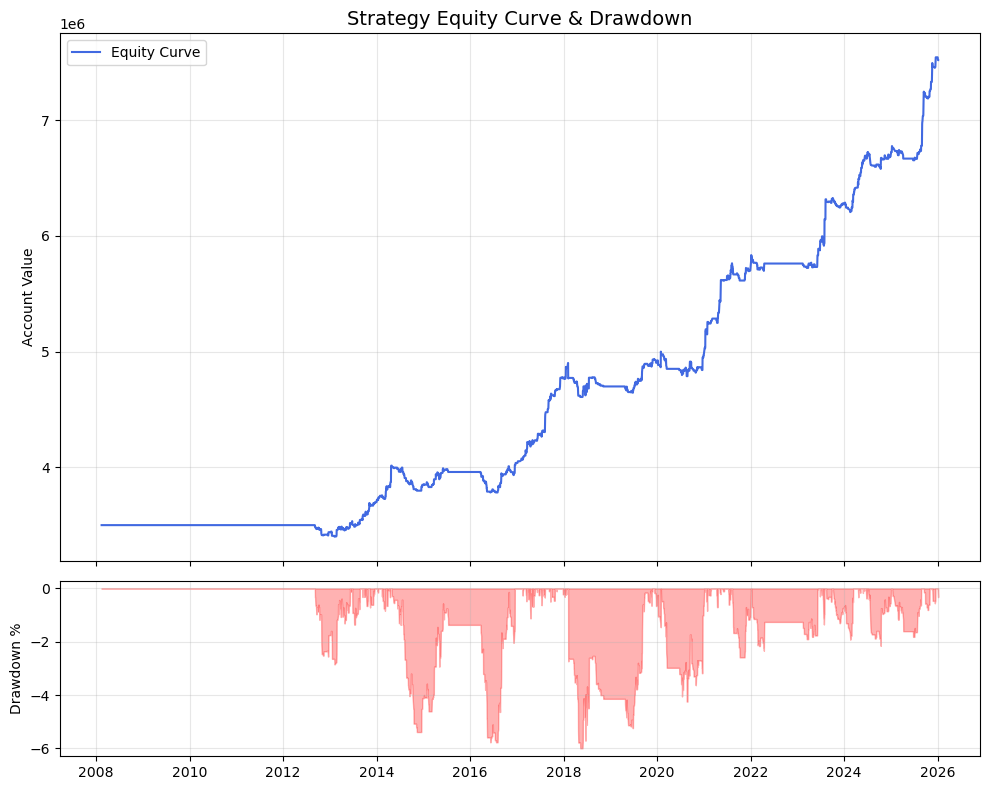

In [8]:
# ======================================
# [新增功能] 策略核心績效指標計算 (MDD, Sharpe, Profit Factor, CAGR)
# ======================================
import numpy as np

# 1. 準備金設定 (以您之前算出的最高曝光額作為本金參考值)
INITIAL_CAPITAL = 3500000  # 假設準備金為 450 萬

# 2. 建立每日權益曲線 (Realized PnL)
# 先統計每日實現損益
daily_realized_pnl = df_trades.groupby("exit_date")["pnl"].sum().reindex(backtest_dates, fill_value=0)
# 累計損益 + 本金
equity_curve = daily_realized_pnl.cumsum() + INITIAL_CAPITAL

# 3. 計算最大回撤 (MDD)
# 找出歷史最高點
running_max = equity_curve.cummax()
# 計算回撤金額與百分比
drawdown_amt = equity_curve - running_max
drawdown_pct = drawdown_amt / running_max
mdd_pct = drawdown_pct.min()
mdd_date = drawdown_pct.idxmin()

# 4. 計算年化報酬率 (CAGR)
total_days = (backtest_dates[-1] - backtest_dates[0]).days
years = total_days / 365.25
total_return = (equity_curve.iloc[-1] / INITIAL_CAPITAL) - 1
cagr = (1 + total_return)**(1/years) - 1

# 5. 計算夏普比率 (Sharpe Ratio)
# 使用每日收益率計算（假設無風險利率為 1%）
daily_returns = equity_curve.pct_change().dropna()
# 年化報酬率 / 年化標普 (通常乘上 sqrt(252) 代表交易日)
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# 6. 獲利因子 (Profit Factor)
gross_profit = df_trades[df_trades['pnl'] > 0]['pnl'].sum()
gross_loss = abs(df_trades[df_trades['pnl'] < 0]['pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

# ======================================
# 顯示報表
# ======================================
print("-" * 30)
print(f"策略效能總結表 (基準本金: {INITIAL_CAPITAL:,.0f})")
print("-" * 30)
print(f"1. 總損益 (PnL):      {df_trades['pnl'].sum():,.0f} 元")
print(f"2. 總報酬率:          {total_return*100:.2f} %")
print(f"3. 年化報酬率 (CAGR): {cagr*100:.2f} %")
print(f"4. 最大回撤 (MDD):    {mdd_pct*100:.2f} %")
print(f"5. 獲利因子 (PF):     {profit_factor:.2f}")
print(f"6. 夏普比率 (Sharpe): {sharpe_ratio:.2f}")
print("-" * 30)
print(f"MDD 發生日期: {mdd_date.date()}")

# 繪製資產曲線與回撤圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(equity_curve, color='royalblue', label='Equity Curve')
ax1.set_title("Strategy Equity Curve & Drawdown", fontsize=14)
ax1.set_ylabel("Account Value")
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.fill_between(drawdown_pct.index, drawdown_pct * 100, 0, color='red', alpha=0.3)
ax2.set_ylabel("Drawdown %")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()